### Model Construction and Evaluation

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
cwd = os.getcwd().replace('/notebooks','')
data_dir = os.path.join(cwd, 'data')
np.random.seed(6)

In [4]:
%matplotlib inline

In [5]:
#Concatenate all csv files under a directory
def csv_concatenate(folder_path):
    files = glob.glob(folder_path + "/*.csv")
    df_list = []
    for file in tqdm(files):
        df_list.append(pd.read_csv(file, parse_dates=True, infer_datetime_format=True))
    #Fill nan with 0s as some values are empty for percentage points
    df = pd.concat(df_list).fillna(0).reset_index(drop=True)
    return df

In [6]:
def calculate_MAE(pred, true):
    n = len(pred)
    abs_error = 0 
    for i in range(n):
        abs_error += abs(pred[i] - true[i])
    mae = abs_error/n
    return mae

In [7]:
def calculate_RMSE(pred, true):
    return np.sqrt(mean_squared_error(pred, true))

In [8]:
def calculate_FPTS(df):
    #Scoring rules based on https://www.draftkings.co.uk/help/rules/4
    multipliers = {'PTS':1, '3P': 0.5, 'TRB':1.25, 'AST':1.5, 'STL':2, 'BLK':2, 'TOV':-0.5}
    
    indices = len(df)
    fpts_list = []
    
    for i in tqdm(range(indices)):
        fpts = 0
        doubles = 0
        for stat, multiplier in multipliers.items():
            if stat in ['PTS', 'TRB', 'AST', 'STL', 'BLK']:
                if df.loc[i, stat] >= 10:
                    doubles += 1
            fpts += df.loc[i, stat]*multiplier
        if doubles >= 2:
            fpts += 1.5
        if doubles >= 3:
            fpts += 3
        fpts_list.append(fpts) 
        
    return fpts_list

In [9]:
def cross_val(reg_base, X, y, show_train=False):
    mae_results_train = []
    rmse_results_train = []
    
    mae_results_test = []
    rmse_results_test = []
    
    for k in tqdm(range(5)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=k)
        reg = reg_base
        
        reg.fit(X_train, y_train)
        
        y_pred_train = reg.predict(X_train)
        
        mae_results_train.append(calculate_MAE(y_pred_train, y_train))
        rmse_results_train.append(calculate_RMSE(y_pred_train, y_train))
        
        y_pred_test = reg.predict(X_test)
        
        mae_results_test.append(calculate_MAE(y_pred_test, y_test))
        rmse_results_test.append(calculate_RMSE(y_pred_test, y_test))
    
    if show_train==True:
        print('[TRAIN]')
        print('MAE:', np.mean(mae_results_train))
        print('RSME:', np.mean(rmse_results_train))
        print('\n[TEST]')
    
    print('MAE:', np.mean(mae_results_test))
    print('RSME:', np.mean(rmse_results_test))
    return rmse_results_test

### 1. Baseline - Simple Average

In [10]:
df_baseline = csv_concatenate(os.path.join(data_dir, 'Dataframes','modelling', 'baseline'))
df_baseline['FPTS_pred'] = calculate_FPTS(df_baseline)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=112693), HTML(value='')))

In [11]:
print('MAE:', calculate_MAE(df_baseline['FPTS_pred'], df_baseline['FPTS']))
print('RMSE:', calculate_RMSE(df_baseline['FPTS_pred'], df_baseline['FPTS']))

MAE: 7.426654480369171
RMSE: 9.859323780303217


### Linear Regression with basic 9 variables 

In [12]:
df_baseline = df_baseline.sort_values(by=['Date','Name']).reset_index(drop=True)

In [13]:
basic =  ['PTS','3P','AST','TRB','STL','BLK','TOV', 'DD', 'TD']

In [14]:
X = df_baseline.loc[:, basic]
X = MinMaxScaler().fit_transform(X)
y = df_baseline['FPTS'].values.reshape(-1,1).flatten()

reg = LinearRegression()
cross_val(reg, X, y)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MAE: 7.504432561108371
RSME: 9.78312739824315


[9.758496529003205,
 9.761115820444461,
 9.755005159963906,
 9.811935422871546,
 9.829084058932644]

### 3. Weighted Model

Choose weighting scheme

In [15]:
original_stats = ['SG', 'F', 'C', 'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'DD', 'TD', 'MP', 'FT',
                  'FTA', 'FGA', '3PA', 'DRB', 'ORB', 'USG_perc', 'DRtg', 'ORtg', 'AST_perc', 'DRB_perc',
                  'ORB_perc', 'BLK_perc', 'TOV_perc', 'STL_perc', 'eFG_perc', 'FG_perc', '3P_perc', 'FT_perc']
len(original_stats)

32

### Choosing the best weighting scheme

In [ ]:
for weighting in ['sqrt', 'linear', 'quad']:
    df_features = csv_concatenate(os.path.join(data_dir, 'Dataframes','modelling', 'features', weighting))  
    
    X = df_features.loc[:, original_stats]
    X = MinMaxScaler().fit_transform(X)
    y = df_features['FPTS'].values.reshape(-1,1).flatten()

    reg = LinearRegression()
    cross_val(reg, X, y)

In [ ]:
pd.DataFrame({'Square Root':[7.252586715071312, 9.582256361344033],
              'Linear':[7.212408190947604, 9.543677566513761],
              'Quadratic':[7.196346318159108, 9.535559958416505]},
             index=['MAE', 'RMSE']).loc[:,['Square Root', 'Linear', 'Quadratic']]

In [16]:
weighting = 'quad'

df_features = csv_concatenate(os.path.join(data_dir, 'Dataframes','modelling', 'features', weighting))
df_features['FPTS_pred'] = calculate_FPTS(df_features)

print('MAE:', calculate_MAE(df_features['FPTS_pred'], df_features['FPTS']))
print('RMSE:', calculate_RMSE(df_features['FPTS_pred'], df_features['FPTS']))

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

HBox(children=(IntProgress(value=0, max=95982), HTML(value='')))


MAE: 7.257679591979837
RMSE: 9.702762983596946


### Linear Regression with basic 9 variables 

In [17]:
X = df_features.loc[:, basic]
X = MinMaxScaler().fit_transform(X)
y = df_features['FPTS'].values.reshape(-1,1).flatten()

reg = LinearRegression()
cross_val(reg, X, y)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MAE: 7.3235864125322845
RSME: 9.59146937971505


[9.57752064729448,
 9.64427815818899,
 9.599608254012498,
 9.582541821660687,
 9.553398017418605]

### Feature Selection with Correlation Matrix and Feature Importances

In [18]:
numerical = ['Salary', 'Starter', 'Rest', 'Rota_All', 'Rota_Pos', 'Home', 'SG', 'F', 'C', 'Value', 'FPTS_std',
             'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'DD', 'TD', 'MP', 'FT', 'FTA', 'FGA', '3PA', 'DRB',
             'ORB', 'USG_perc', 'DRtg', 'ORtg', 'AST_perc', 'DRB_perc', 'ORB_perc', 'BLK_perc', 'TOV_perc', 
             'STL_perc', 'eFG_perc', 'FG_perc', '3P_perc', 'FT_perc']
len(numerical)

40

In [19]:
pandas_profiling.ProfileReport(df_features.loc[:, numerical], correlation_threshold=0.9)

Number of variables,40
Number of observations,95982
Total Missing (%),0.0%
Total size in memory,29.3 MiB
Average record size in memory,320.0 B
Numeric,29
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,6


In [20]:
features = ['Salary', 'Starter', 'Rest', 'Rota_All', 'Rota_Pos', 'Home', 'SG', 'F', 'C', 'Value',
            'FPTS_std', 'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK', 'TOV', 'DD', 'TD', 'MP', 'FT', 'ORB',
            'USG_perc', 'DRtg', 'AST_perc', 'DRB_perc', 'ORB_perc', 'BLK_perc', 'TOV_perc', 'STL_perc',
            'eFG_perc', '3P_perc', 'FT_perc']

print(len(features))
X = df_features.loc[:,features]
X = MinMaxScaler().fit_transform(X)

34


In [21]:
model = GradientBoostingRegressor()
model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

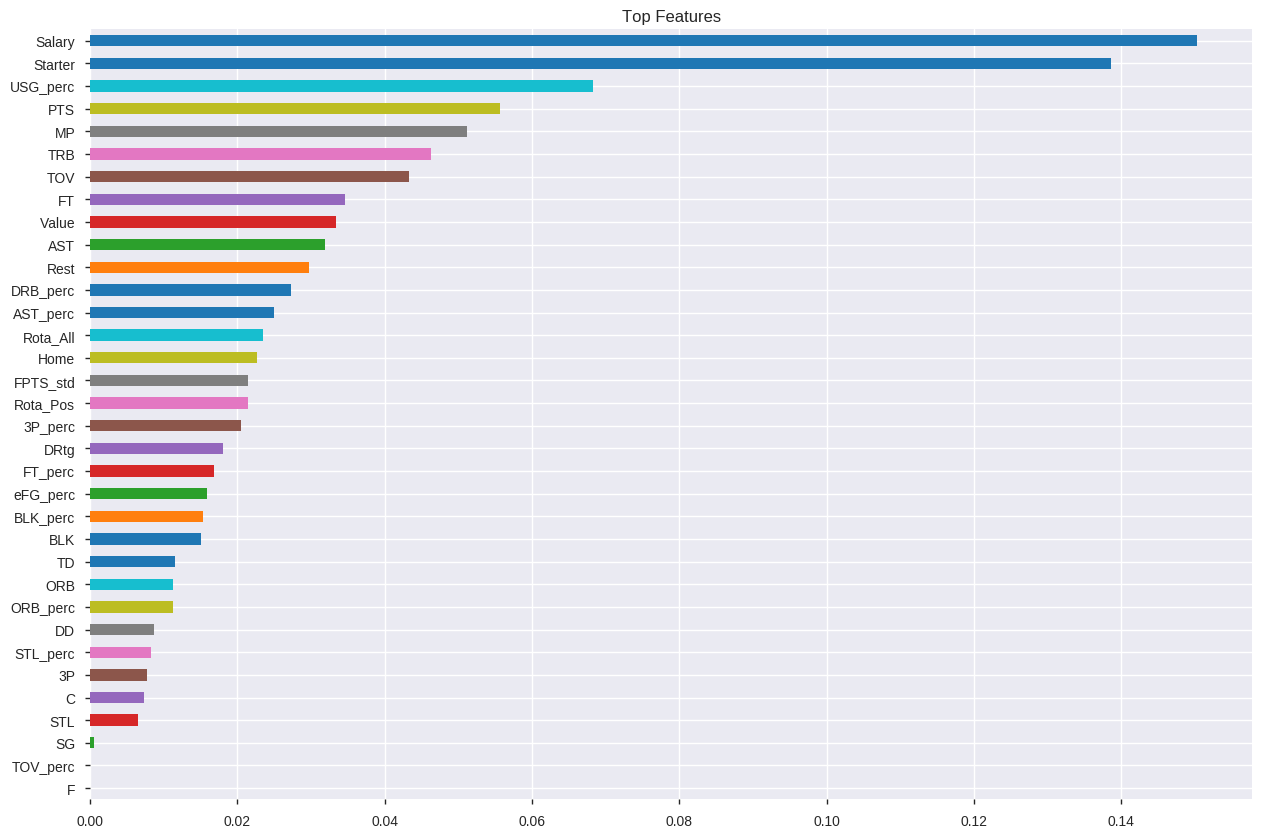

In [22]:
top_features = pd.Series(model.feature_importances_, index = features).sort_values()
top_features.plot(kind = "barh", figsize=(15,10) ,title='Top Features')
plt.show()

In [23]:
selected = list(top_features[5:].index)
len(top_features[5:])

29

### Linear Regression with Selected Features

In [24]:
X = df_features.loc[:, selected]
X = MinMaxScaler().fit_transform(X)

reg = LinearRegression()

reg.fit(X, y)
cross_val(reg, X, y)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MAE: 7.125753916082897
RSME: 9.28803499022045


[9.296059827084592,
 9.31681645688469,
 9.303560020295393,
 9.277817400113294,
 9.245921246724276]

### XGBoost

In [25]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [26]:
reg = xgb.XGBRegressor()
cross_val(reg, X, y, show_train=True)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


[TRAIN]
MAE: 6.922591026512419
RSME: 8.99401442257709

[TEST]
MAE: 6.998993542887442
RSME: 9.100801082225635


[9.10489684519982,
 9.121077184047236,
 9.125333968695292,
 9.085544824224016,
 9.06715258896181]

In [27]:
# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform' for the learning rate)

reg = xgb.XGBRegressor()

space  = [Integer(5, 50, name='max_depth'),
          Integer(100, 500, name='n_estimators'),
          Integer(0,5, name='min_child_weight'),
          Real(0.7, 1.0, name='colsample_bytree'), 
          Real(0.7, 1.0, name='colsample_bylevel'),
          Real(0.8, 1.0, name='subsample'),
          Real(0.0, 1.0, name='gamma'),
          Real(0.001, 0.999, "log-uniform", name='learning_rate'),
         ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return np.sqrt(-np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1, scoring="neg_mean_squared_error")))

In [ ]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=514, n_random_starts=5, verbose=2)

In [ ]:
print("[Best parameters]")
print(
"""'max_depth':{}, 'n_estimators':{}, 'min_child_weight':{}, 'colsample_bytree':{},
'colsample_bylevel':{}, 'subsample':{}, 'gamma':{}, 'learning_rate':{}""".format(
res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3],
res_gp.x[4], res_gp.x[5], res_gp.x[6], res_gp.x[7]))

In [ ]:
from skopt.plots import plot_convergence

plot_convergence(res_gp);

In [28]:
best_parameters = {'max_depth':5, 'n_estimators':500, 'min_child_weight':0, 'colsample_bytree':0.7744934433163122,
                   'colsample_bylevel':0.7, 'subsample':0.7, 'gamma':0.8, 'learning_rate':0.010185577044747623}

best_parameters = {'max_depth':5, 'n_estimators':500, 'min_child_weight':0, 'colsample_bytree':0.9087552779394614,
                   'colsample_bylevel':0.7, 'subsample':0.8, 'gamma':0.0, 'learning_rate':0.013402721880461977
                   }
#MAE: 6.852755706901883, RSME: 8.963593652669738

best_parameters = {'max_depth':5, 'n_estimators':500, 'min_child_weight':5, 'colsample_bytree':0.7,
                   'colsample_bylevel':0.7, 'subsample':0.9397637802105351, 'gamma':0.0,
                   'learning_rate':0.015427690378899695}

#MAE: 6.8531269778653465 RSME: 8.964306564892905

best_parameters = {'max_depth':5, 'n_estimators':354, 'min_child_weight':0, 'colsample_bytree':1.0,
                   'colsample_bylevel':0.7, 'subsample':0.7, 'gamma':0.8, 'learning_rate':0.015256854802380305}
#MAE: 6.850690569710392 RSME: 8.966229735232426

best_parameters = {'max_depth':6, 'n_estimators':250, 'min_child_weight':4, 'colsample_bytree':0.6, 
                   'colsample_bylevel':0.7, 'subsample':1.0, 'gamma':0.0, 'learning_rate':0.026944654231987667}

#MAE: 6.848631675865012, RSME: 8.958142274893145
                
reg = xgb.XGBRegressor(**best_parameters)
cross_val(reg, X, y, show_train=True)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


[TRAIN]
MAE: 6.682503266143419
RSME: 8.661856517980274

[TEST]
MAE: 6.946500330725927
RSME: 9.032348327534796


[9.025248095736675,
 9.041700283010117,
 9.06470280439539,
 9.024117693792855,
 9.00597276073895]

###  Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping 

In [ ]:
es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

In [ ]:
def model_1():
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [ ]:
def model_2():
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [ ]:
def model_3():
    model = Sequential()
    model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [ ]:
model = KerasRegressor(build_fn=model_1,
                       epochs=30,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)
h1 = model.fit(X, y)

In [ ]:
plt.plot(h1.history['loss'])  
plt.plot(h1.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Validation'], loc='upper right')  
plt.show()

In [ ]:
model = KerasRegressor(build_fn=model_2,
                       epochs=30,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)

h2 = model.fit(X, y)

In [ ]:
model = KerasRegressor(build_fn=model_3,
                       epochs=30,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)

h3 = model.fit(X, y)

In [ ]:
for hist in [h1, h3]:
    plt.subplot(111)  
    plt.plot(hist.history['loss'])  
    plt.plot(hist.history['val_loss'])  
    plt.title('Model Loss')  
    plt.ylabel('Loss')  
    plt.xlabel('Epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')  
    plt.show()

In [ ]:
model = KerasRegressor(build_fn=model_1,
                       epochs=30,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)

kfold = KFold(n_splits=5, shuffle=True)

In [ ]:
results_MAE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_absolute_error')
results_RMSE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_squared_error')

In [ ]:
print(np.sqrt(-results_RMSE))
print("Results: %.4f RMSE" % np.sqrt(np.mean(-results_RMSE)))

print(np.sqrt(-results_MAE))
print("Results: %.4f MAE" % np.mean(-results_MAE))

In [ ]:
model = KerasRegressor(build_fn=model_3,
                       epochs=15,
                       batch_size=32,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)

kfold = KFold(n_splits=5, shuffle=True)

In [ ]:
results_MAE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_absolute_error')
results_RMSE = cross_val_score(model, X, y, cv=kfold, n_jobs=1, scoring='neg_mean_squared_error')

In [ ]:
print(np.sqrt(-results_RMSE))
print("Results: %.4f RMSE" % np.sqrt(np.mean(-results_RMSE)))

print(np.sqrt(-results_MAE))
print("Results: %.4f MAE" % np.mean(-results_MAE))

### Prediction

In [32]:
### Train Test Split
X = df_features.sort_values(by=['Date','Name']).reset_index(drop=True)

target_month = 201803

df_features['Date']

start = 20180301
end = 20180331

test_indices = (df_features['Date'] >= start) & (df_features['Date'] <= end)
train_indices = [not value for value in test_indices]

X_train = df_features.loc[train_indices, ['Date'] + selected]
X_test = df_features.loc[test_indices, selected]

y_train = df_features.loc[train_indices, 'FPTS'].values.reshape(-1,1).flatten()
y_test = df_features.loc[test_indices, 'FPTS'].values.reshape(-1,1).flatten()

#X_train = MinMaxScaler().fit_transform(X_train)
#X_test = MinMaxScaler().fit_transform(X_test)

In [33]:
X_train

,Date,3P,STL_perc,DD,ORB_perc,ORB,TD,BLK,BLK_perc,eFG_perc,...,AST,Value,FT,TOV,TRB,MP,PTS,USG_perc,Starter,Salary
0,20151113,1.618182,1.904935,0.000000,0.677403,0.137662,0.0,0.000000,0.000000,0.531906,...,4.451948,4.587636,0.462338,1.974026,1.400000,22.607429,11.441558,24.863636,0,4400.0
1,20151113,1.379221,3.657403,0.000000,0.149610,0.046753,0.0,0.566234,1.517662,0.512182,...,2.753247,6.049127,1.722078,2.353247,4.446753,30.777844,12.644156,19.556364,1,5400.0
2,20151113,1.145455,3.220519,0.259740,1.630390,0.423377,0.0,1.135065,2.792987,0.449652,...,8.210390,5.676438,3.361039,3.106494,2.142857,30.961351,17.311688,29.482857,1,7000.0
3,20151113,0.397403,2.712987,0.000000,2.227532,0.332468,0.0,0.374026,0.991169,0.236808,...,0.755844,2.330303,0.000000,0.496104,1.236364,10.653117,2.542857,16.334026,0,3000.0
4,20151113,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.046753,0.000000,0.187013,0.187013,0.724675,0.000000,2.328312,0,3000.0
5,20151113,1.368831,3.536623,0.485714,6.559481,1.851948,0.0,1.075325,2.566234,0.546073,...,3.950649,5.720268,4.587013,2.114286,9.841558,33.848390,19.005195,23.587792,1,8000.0
6,20151113,0.402597,0.000000,0.000000,4.705714,0.548052,0.0,0.000000,0.000000,0.506917,...,0.716883,2.568831,0.903896,0.587013,1.532468,10.976312,4.807792,13.102857,0,3000.0
7,20151113,1.623377,0.940000,0.106494,9.691169,2.524675,0.0,1.574026,4.564675,0.584969,...,2.888312,5.077635,1.623377,1.587013,7.807792,30.995974,18.218182,24.056883,1,7200.0
8,20151114,5.072727,4.004675,0.093506,1.031169,0.342857,0.0,0.345455,0.808571,0.615192,...,4.914286,5.157054,6.407792,3.776623,5.231169,35.902416,32.592208,33.249870,1,10700.0
9,20151114,0.000000,1.336883,0.000000,3.911948,0.677922,0.0,0.137662,0.630390,0.641299,...,2.454545,3.950376,0.607792,0.750649,1.412987,20.173974,5.485714,10.733506,0,3000.0


In [ ]:
pred_baseline = df_baseline.loc[(df_baseline['Date'] >= start) & (df_baseline['Date'] <= end), 'FPTS_pred'].reset_index(drop=True)
actual = df_baseline.loc[(df_baseline['Date'] >= start) & (df_baseline['Date'] <= end), 'FPTS'].reset_index(drop=True)
print(calculate_MAE(pred_baseline, actual))
print(calculate_RMSE(pred_baseline, actual))

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
pred_lm = reg.predict(X_test)
print(calculate_MAE(pred_lm, y_test))
print(calculate_RMSE(pred_lm, y_test))

In [ ]:
"""best_parameters = {'max_depth':5, 'n_estimators':500, 'min_child_weight':0, 'colsample_bytree':0.7744934433163122,
                   'colsample_bylevel':0.7, 'subsample':0.7, 'gamma':0.8, 'learning_rate':0.010185577044747623}
#9.358073767342875

best_parameters = {'max_depth':5, 'n_estimators':354, 'min_child_weight':0, 'colsample_bytree':1.0,
                   'colsample_bylevel':0.7, 'subsample':0.7, 'gamma':0.8, 'learning_rate':0.015256854802380305}
#6.993397555914223 9.152592657777618"""

best_parameters = {'max_depth':6, 'n_estimators':250, 'min_child_weight':4, 'colsample_bytree':0.6, 
                   'colsample_bylevel':0.7, 'subsample':1.0, 'gamma':0.0, 'learning_rate':0.026944654231987667}

reg = xgb.XGBRegressor(**best_parameters)
reg.fit(X_train, y_train, verbose=1)
pred_xgb = reg.predict(X_test)
print(calculate_MAE(pred_xgb, y_test))
print(calculate_RMSE(pred_xgb, y_test))

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [ ]:
def advanced_model():
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
model = KerasRegressor(build_fn=advanced_model,
                       epochs=30,
                       batch_size=64,
                       validation_split=0.2,
                       shuffle=True,
                       verbose=1)

h = model.fit(X_train, y_train)

In [ ]:
pred_nn = model.predict(X_test)
print(calculate_MAE(pred_nn, y_test))
print(calculate_RMSE(pred_nn, y_test))

### Write prediction into csv

In [29]:
df_pred = df_features.loc[test_indices, ['Date', 'Name', 'Team', 'FPTS', 'Pos', 'Salary']]
df_pred['Pred'] = pred_xgb

NameError: name 'test_indices' is not defined

In [ ]:
df_pred.to_csv(os.path.join(data_dir, 'Prediction/20180514.csv'), index=False)